In [1]:
import pandas as pd
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input,BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array 



In [3]:
img_size=150
batch_size=32

traingen=ImageDataGenerator(rescale=1/255.,
                           brightness_range=[0.2,1.2],
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           horizontal_flip=True)
#rescale ==> Rescales the pixel values with the 0-1 range
#Randomly rotates the image, max. 50 degree
#Randomly set the brightness of the image within the given range


testgen=ImageDataGenerator(rescale=1/255.)

valgen=ImageDataGenerator(rescale=1/255.,                    
                           brightness_range=[0.2,1.2],
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           horizontal_flip=True)

In [4]:
traindata=traingen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/train',
                                   target_size=(img_size,img_size),
                                   batch_size = batch_size,
                                   shuffle=True,
                                   class_mode='binary',
                                   color_mode='grayscale')
testdata=testgen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/test',
                                    shuffle=False,
                                    batch_size=batch_size,
                                    target_size=(img_size,img_size),
                                    class_mode='binary',
                                    color_mode='grayscale')
valdata=valgen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/val',
                                  shuffle=False,
                                    batch_size=batch_size,
                                   target_size=(img_size,img_size),
                                   class_mode='binary',
                                   color_mode='grayscale'
                                  )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [5]:

os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
model=Sequential() #Layer by layer NN starts here
model.add(Conv2D(32,(2,2),input_shape=(img_size,img_size,1),activation="relu",padding='same',strides=1))
#32 Filters of size 2x2, input shape of the image in given size and grayscale, using relu activation function, stride is the step size
model.add(MaxPooling2D())
#Pooling and decreasing of the dimensions
model.add(Conv2D(64,(2,2),strides=2,activation="relu",padding="same"))
#64 filters and larger strides of 2
model.add(MaxPooling2D())
model.add(Conv2D(128,(2,2), strides=1,activation="relu",padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
#Flattens the previous layer, converting the multi-dimentional image to a complete single-dimension
model.add(Dense(128,activation="relu"))
#Fully connected network with 128 neurons
model.add(Dense(1,activation='sigmoid'))
#Final output layer with only one neuron, satisfying our need of classifying binary

In [6]:
model.compile(optimizer = 'adam', loss='binary_crossentropy',metrics=['accuracy'])

In [7]:
history=model.fit(traindata,validation_data=valdata, epochs=15)

Epoch 1/15
163/163 [==============================] - 104s 628ms/step - loss: 0.4147 - accuracy: 0.8173 - val_loss: 0.8873 - val_accuracy: 0.7500
Epoch 2/15
163/163 [==============================] - 79s 482ms/step - loss: 0.2350 - accuracy: 0.9078 - val_loss: 1.1039 - val_accuracy: 0.8125
Epoch 3/15
163/163 [==============================] - 80s 493ms/step - loss: 0.2011 - accuracy: 0.9235 - val_loss: 1.1558 - val_accuracy: 0.6250
Epoch 4/15
163/163 [==============================] - 81s 496ms/step - loss: 0.1802 - accuracy: 0.9310 - val_loss: 0.9702 - val_accuracy: 0.6875
Epoch 5/15
163/163 [==============================] - 81s 494ms/step - loss: 0.1755 - accuracy: 0.9304 - val_loss: 0.7177 - val_accuracy: 0.6250
Epoch 6/15
163/163 [==============================] - 80s 489ms/step - loss: 0.1653 - accuracy: 0.9367 - val_loss: 1.1236 - val_accuracy: 0.5625
Epoch 7/15
163/163 [==============================] - 80s 490ms/step - loss: 0.1576 - accuracy: 0.9419 - val_loss: 0.9714 - val_a

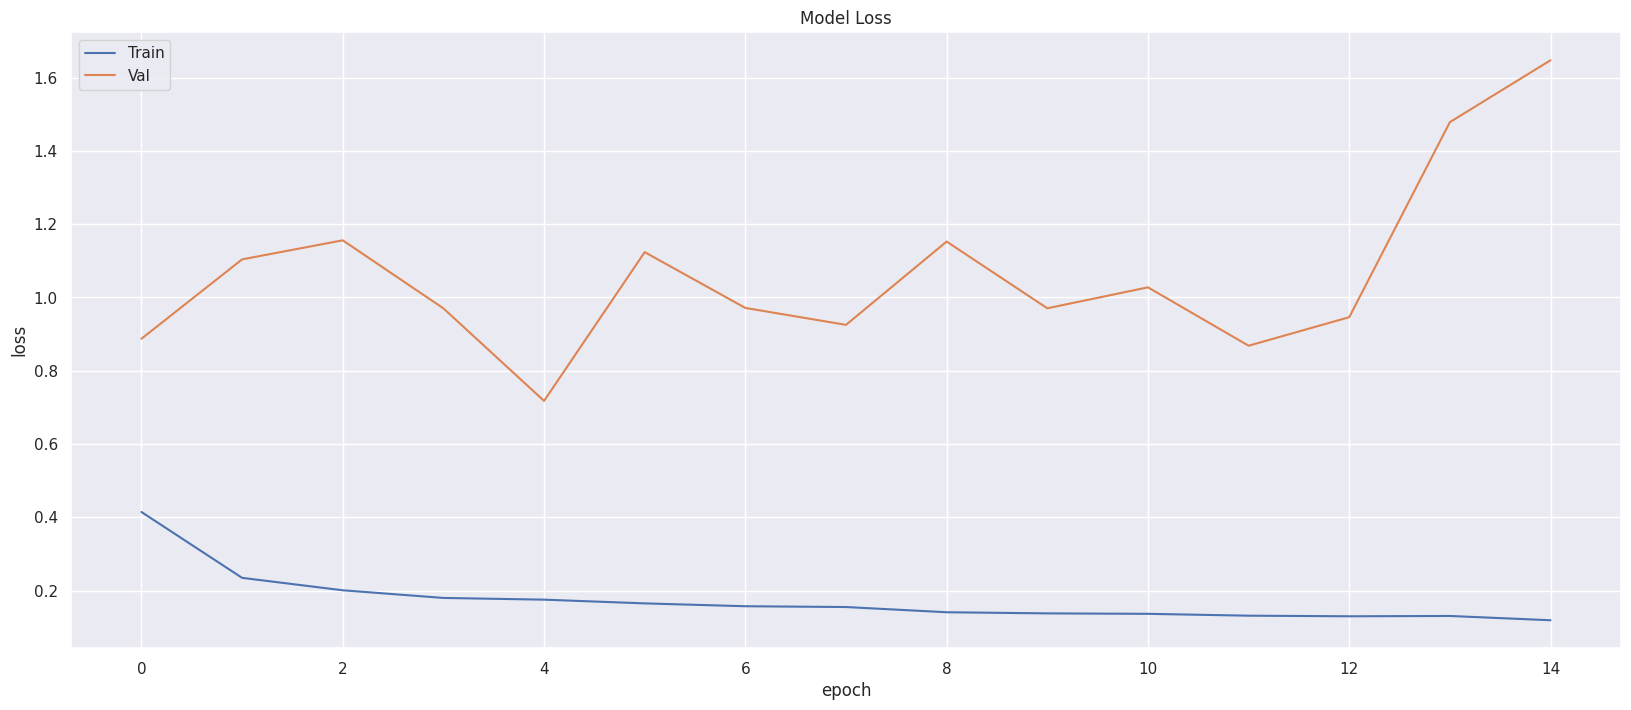

In [8]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
#plot the training loss over every epoch
plt.plot(history.history['val_loss'])
#plot the validation loss
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

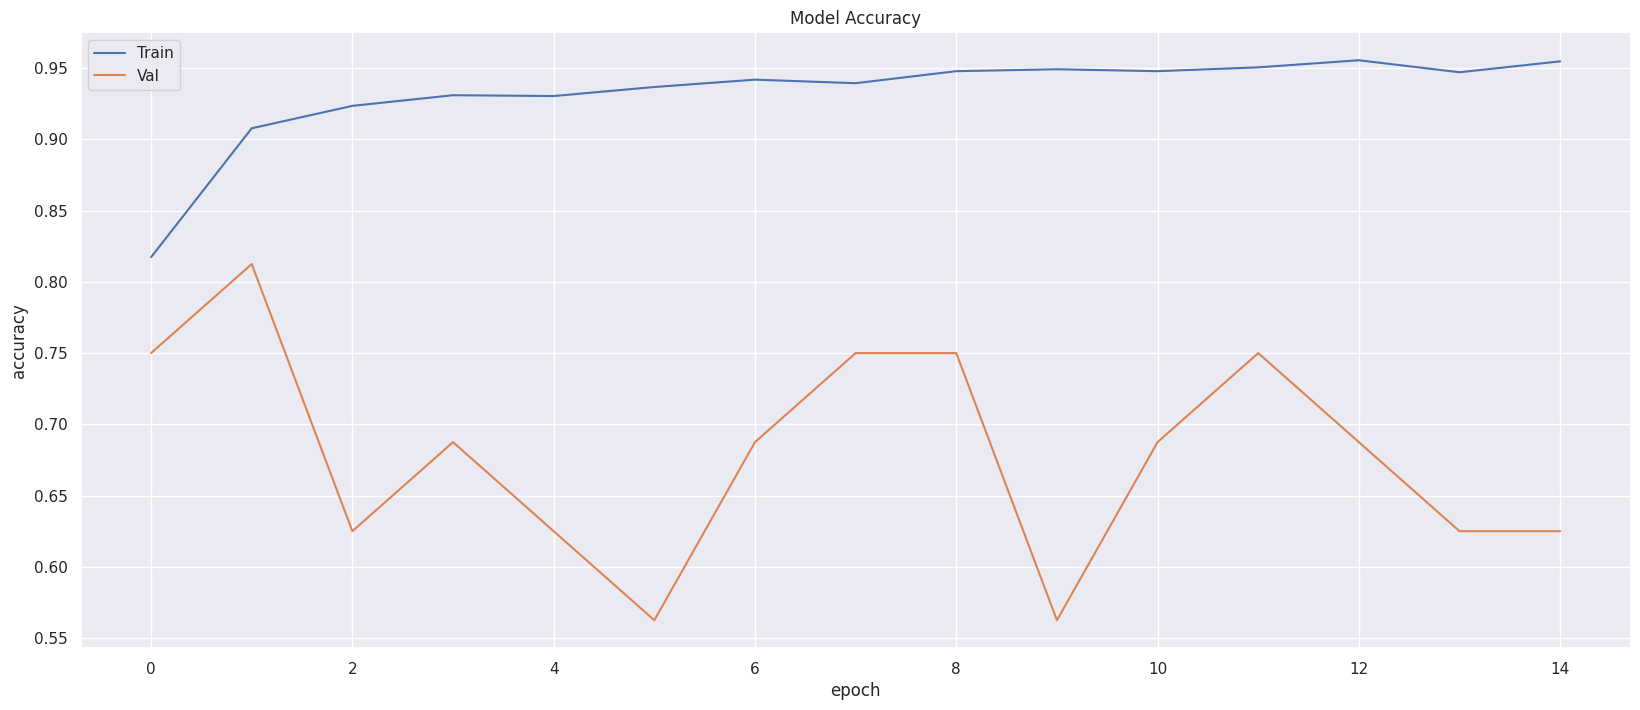

In [9]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
#plot the training accuracy over all the epochs
plt.plot(history.history['val_accuracy'])
#plot the validation accuracy over all the epochs
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

In [10]:
y_test=valdata.classes
#has all the labels in form of binary for all the samples in the validation dataset
y_pred=model.predict(valdata)
#predicts the probabilities of every sample in the validation dataset using the trained model
y_pred_probs=y_pred.copy()
#saves a copy of the predicted probabilities
y_pred[y_pred>0.5]=1
#makes all the predictions with probability greater that 0.5 equal to calss label 1 
y_pred[y_pred<0.5]=0
#makes all the predictions with probability smaller that 0.5 equal to class label 0 

1/1 [==============================] - 0s 335ms/step


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
print(classification_report(y_test, y_pred, target_names=['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       1.00      0.12      0.22         8
   Pneumonia       0.53      1.00      0.70         8

    accuracy                           0.56        16
   macro avg       0.77      0.56      0.46        16
weighted avg       0.77      0.56      0.46        16

